In [21]:
import numpy as np
from scipy import interpolate, integrate
import matplotlib.pyplot as plt

# functions to generate phase-space points for two and three-body decays
import mc
# kinematic functions: boosts, vector products, etc
import kinematics as kin

%matplotlib inline

fig_size = [7, 3.15]
                   
# Latex params
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 10,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'axes.linewidth':0.5,
          'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['Computer Modern Roman'],
          'xtick.major.pad': 8,
          'ytick.major.pad': 8,
          'figure.figsize':fig_size}

plt.rcParams.update(params)


def get_kin_list(Nevt, ME_func):
    """
    Generates Nevt events using ME_func matrix element function,
    returns Nevt-long lists of proton, pi1, pi2 four_vectors, and event weights
    Note that the decay matrix elements can depend on lab-frame kinematics, 
    so if these change, make sure to propagate the changes into the ME functions
    """
    mp = 0.93827
    mpi = 0.139570
    Egamma = 3.
    
    # Lab-frame gamma+proton momentum
    pGamma = np.array([Egamma, 0., 0., Egamma])
    ppstar = pGamma + np.array([mp,0.,0.,0.])
    Mpstar = np.sqrt(kin.lor_prod(ppstar,ppstar))
      
    
    print "Mpstar = ", Mpstar
    
    pi1_four_vectors = []
    pi2_four_vectors = []
    p_four_vectors = []
    
    weight_list = []

    for i in np.arange(Nevt):           
        pp, ppi1, ppi2 = mc.gen_three_body_decay_products(ppstar, Mpstar, mp, mpi, mpi)

        weight_list.append(mc.get_three_body_weight(Mpstar, mp, mpi, mpi, pp, ppi1, ppi2, ME_func))

        pi1_four_vectors.append(ppi1)
        pi2_four_vectors.append(ppi2)
        p_four_vectors.append(pp)
        #pi_four_vectors.append(ppi2)
            
    return np.array(p_four_vectors), np.array(pi1_four_vectors), np.array(pi2_four_vectors), np.array(weight_list)


# ME_Default ( trivial ME)

In [22]:
def mat_el_default(M, m1, m2, m3, p1, p2, p3):
    # M = gamma+proton mass, m1 = proton, m2, m3 = pion masses
    # p1 = proton, p2 = pi+, p3 = pi-
    return 1.

In [23]:
# Generate events
p_four_vectors, pi1_four_vectors, pi2_four_vectors, weight_list = get_kin_list(100000,mat_el_default)

Mpstar =  2.55146440165


In [24]:
# Get z components of the 4 vectors
pi1_pzs = pi1_four_vectors[:,3]
pi2_pzs = pi2_four_vectors[:,3]
p_pzs = p_four_vectors[:,3]
print min(pi1_pzs), max(pi2_pzs)

-0.361996328848 2.80370685145


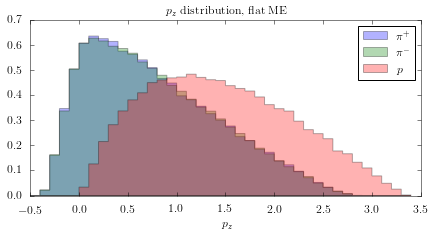

In [25]:
# Draw pz distribution
pz_bins = np.arange(-0.5,3.5,0.1)

a = plt.hist(pi1_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^+$')
a = plt.hist(pi2_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^-$')
a = plt.hist(p_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$p$')
plt.xlabel(r'$p_z$')

plt.title(r'$p_z$ distribution, flat ME')

plt.legend()

#plt.savefig("graphics/IDM_Esum_hist_m1_10MeV.pdf", format='PDF', dpi=1000, bbox_inches='tight')

In [26]:
# Get invariant masses
s_ppi1 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi1_four_vectors)])
s_ppi2 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi2_four_vectors)])
s_pipi = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(pi1_four_vectors, pi2_four_vectors)])

In [27]:
[min(s_ppi1), max(s_ppi1)], [min(s_ppi2), max(s_ppi2)], [min(s_pipi), max(s_pipi)]

([1.0789618669813155, 2.4106968051262792],
 [1.0780376176573243, 2.4116282953299666],
 [0.27916815302996756, 1.613191865789513])

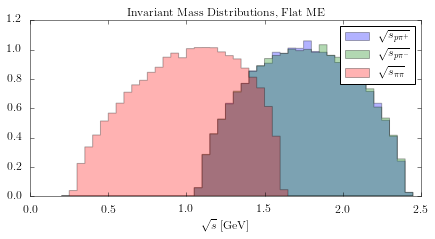

In [28]:
# Make invariant mass plot
s_pipi_bins =  np.arange(0.2,2.5,0.05) 

a = plt.hist(s_ppi1,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^+}}$')
a = plt.hist(s_ppi2,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^-}}$')
a = plt.hist(s_pipi,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{\pi\pi}}$')

plt.title(r'Invariant Mass Distributions, Flat ME')
plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.legend()

# ME_Delta ( Delta Resonance)

In [29]:
def mat_el_delta(Mpstar, m1, m2, m3, p1, p2, p3):
    # Mpstar = gamma+proton mass, m1 = proton, m2, m3 = pion masses
    # p1 = proton, p2 = pi+, p3 = pi-
    mp = 0.93827
    mpi = 0.139570
    
    M_Delta=1.232
    G_Delta=0.117
    slope_Delta = 0.06

    #sPiplusProton is the invariant mass of the pi+ and proton.
    #cosThetaCM_Delta is the CM-frame polar angle of the Delta (the pi+proton pair)

    pDelta = p1+p2
    sPiplusProton = kin.lor_prod(pDelta,pDelta)

    sGammaProton = Mpstar**2
    # Magnitude of Gamma 3-momentum in the CM frame
    pGammaCM = (sGammaProton - mp**2)/(2.*np.sqrt(sGammaProton))
    # Magnitude of Delta 3-momentum in the CM frame; Delta recoils against pi-
    # Note that Delta is not necessarily on-shell!
    M_DeltaStar = np.sqrt(sPiplusProton)
    pDeltaCM = np.sqrt( (sGammaProton - M_DeltaStar**2 - mpi**2)**2 - 4.*M_DeltaStar**2 * mpi**2 )/(2.*np.sqrt(sGammaProton))
    EDeltaCM = np.sqrt( M_DeltaStar**2 + pDeltaCM**2 )

    
    # HARDCODED LAB-FRAME KINEMATICS!
    Egamma = 3.
    # Lab-frame gamma+proton momentum
    pGamma = np.array([Egamma, 0., 0., Egamma])
    
    cosThetaCM_Delta = (EDeltaCM - kin.lor_prod(pDelta,pGamma)/pGammaCM)/pDeltaCM
    if not (np.fabs(cosThetaCM_Delta) <= 1.):
        print cosThetaCM_Delta
    assert np.fabs(cosThetaCM_Delta) <= 1.

    norm_Delta =  M_Delta * G_Delta/np.pi / slope_Delta

    BW_den_Delta = (sPiplusProton-M_Delta*M_Delta)**2 + M_Delta*M_Delta*G_Delta*G_Delta

    ME_Delta = norm_Delta * np.exp(-(1.-cosThetaCM_Delta)/slope_Delta) / BW_den_Delta
    #ME_Delta = norm_Delta / BW_den_Delta

    return ME_Delta

In [30]:
p_four_vectors, pi1_four_vectors, pi2_four_vectors, weight_list = get_kin_list(100000,mat_el_delta)

Mpstar =  2.55146440165


In [31]:
# get z components
pi1_pzs = pi1_four_vectors[:,3]
pi2_pzs = pi2_four_vectors[:,3]
p_pzs = p_four_vectors[:,3]
print min(pi1_pzs), max(pi2_pzs)

-0.36991131773 2.81620727256


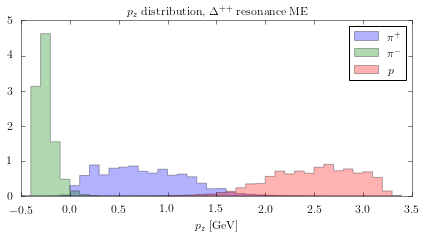

In [32]:
pz_bins = np.arange(-0.5,3.5,0.1)

a = plt.hist(pi1_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^+$')
a = plt.hist(pi2_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^-$')
a = plt.hist(p_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$p$')
plt.xlabel(r'$p_z$ [GeV]')
plt.title(r'$p_z$ distribution, $\Delta^{++}$ resonance ME')

plt.legend()

#plt.savefig("graphics/IDM_Esum_hist_m1_10MeV.pdf", format='PDF', dpi=1000, bbox_inches='tight')

In [33]:
s_ppi1 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi1_four_vectors)])
s_ppi2 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi2_four_vectors)])
s_pipi = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(pi1_four_vectors, pi2_four_vectors)])

In [34]:
[min(s_ppi1), max(s_ppi1)], [min(s_ppi2), max(s_ppi2)], [min(s_pipi), max(s_pipi)]

([1.078573181557881, 2.411599585538402],
 [1.0790247382900349, 2.4118599552356801],
 [0.27916642995494334, 1.6131810591299971])

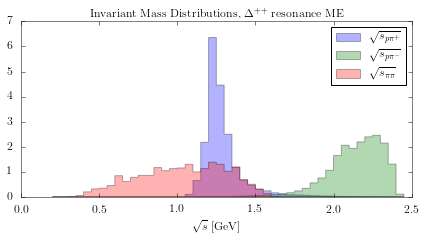

In [35]:
s_pipi_bins =  np.arange(0.2,2.5,0.05) 

a = plt.hist(s_ppi1,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^+}}$')
a = plt.hist(s_ppi2,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^-}}$')
a = plt.hist(s_pipi,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{\pi\pi}}$')

plt.title(r'Invariant Mass Distributions, $\Delta^{++}$ resonance ME')
plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.legend()

# ME_Rho ( Rho Resonance)

In [38]:
def mat_el_rho(Mpstar, m1, m2, m3, p1, p2, p3):
    # M = gamma+proton mass, m1 = proton, m2, m3 = pion masses
    # p1 = proton, p2 = pi+, p3 = pi-
    mp = 0.93827
    mpi = 0.139570
    
    M_rho=0.775
    G_rho=0.149
    slope_rho = 0.06

    #s_pipi is the invariant mass of the pi+ and pi-.
    #cosThetaCM_rho is the CM-frame polar angle of the rho (the pi+pi- system)
    pRho = p2+p3
    s_pipi = kin.lor_prod(pRho,pRho)

    sGammaProton = Mpstar**2
    # Magnitude of Gamma 3-momentum in the CM frame
    pGammaCM = (sGammaProton - mp**2)/(2.*np.sqrt(sGammaProton))
    # Magnitude of Rho 3-momentum in the CM frame, rho recoils against p
    # Note that rho isn't necessarily on-shell!
    M_rhoStar = np.sqrt(s_pipi)
    pRhoCM = np.sqrt( (sGammaProton - M_rhoStar**2 - mp**2)**2 - 4.*M_rhoStar**2 * mp**2 )/(2.*np.sqrt(sGammaProton))
    ERhoCM = np.sqrt( M_rhoStar**2 + pRhoCM**2 )

    # HARDCODED LAB-FRAME KINEMATICS!
    Egamma = 3.
    # Lab-frame gamma+proton momentum
    pGamma = np.array([Egamma, 0., 0., Egamma])
    
    cosThetaCM_rho = (ERhoCM - kin.lor_prod(pRho,pGamma)/pGammaCM)/pRhoCM
    if not (np.fabs(cosThetaCM_rho) <= 1.):
        print cosThetaCM_rho
    assert np.fabs(cosThetaCM_rho) <= 1.

    norm_rho =  M_rho * G_rho/np.pi / slope_rho

    BW_den_rho = (s_pipi-M_rho*M_rho)**2 + M_rho * M_rho * G_rho * G_rho

    ME_rho = norm_rho * np.exp(-(1-cosThetaCM_rho)/slope_rho) / BW_den_rho
    #ME_rho = norm_rho / BW_den_rho

    return ME_rho

In [39]:
p_four_vectors, pi1_four_vectors, pi2_four_vectors, weight_list = get_kin_list(100000,mat_el_rho)

Mpstar =  2.55146440165


In [40]:
pi1_pzs = pi1_four_vectors[:,3]
pi2_pzs = pi2_four_vectors[:,3]
p_pzs = p_four_vectors[:,3]
print min(pi1_pzs), max(pi2_pzs)

-0.362109185417 2.83457407011


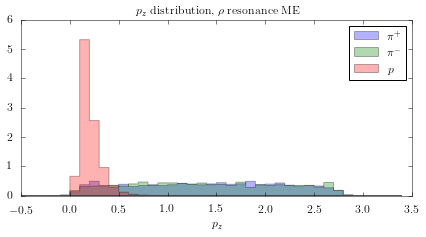

In [41]:
pz_bins = np.arange(-0.5,3.5,0.1)

a = plt.hist(pi1_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^+$')
a = plt.hist(pi2_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^-$')
a = plt.hist(p_pzs,pz_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$p$')
plt.xlabel(r'$p_z$')
plt.title(r'$p_z$ distribution, $\rho$ resonance ME')
plt.legend()

#plt.savefig("graphics/IDM_Esum_hist_m1_10MeV.pdf", format='PDF', dpi=1000, bbox_inches='tight')

In [42]:
s_ppi1 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi1_four_vectors)])
s_ppi2 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi2_four_vectors)])
s_pipi = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(pi1_four_vectors, pi2_four_vectors)])

In [43]:
[min(s_ppi1), max(s_ppi1)], [min(s_ppi2), max(s_ppi2)], [min(s_pipi), max(s_pipi)]

([1.0780881029364842, 2.4114366760109163],
 [1.0780866573586627, 2.4109783883977669],
 [0.27918198169256758, 1.6131906709504942])

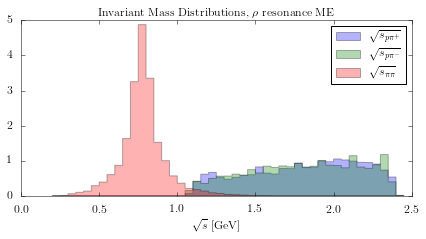

In [44]:
s_pipi_bins =  np.arange(0.2,2.5,0.05) 

a = plt.hist(s_ppi1,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^+}}$')
a = plt.hist(s_ppi2,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^-}}$')
a = plt.hist(s_pipi,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{\pi\pi}}$')

plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.title(r'Invariant Mass Distributions, $\rho$ resonance ME')
plt.legend()

# Adding Histograms and Sample Analysis

In [45]:
# Generate events
# Don't forget to define the matrix elements above

p_four_vectors_del, pi1_four_vectors_del, pi2_four_vectors_del, weight_list_del = get_kin_list(100000,mat_el_delta)
p_four_vectors_rho, pi1_four_vectors_rho, pi2_four_vectors_rho, weight_list_rho = get_kin_list(100000,mat_el_rho)

Mpstar =  2.55146440165
Mpstar =  2.55146440165


In [82]:
# combine events with a relative weight
relative_weight = 1.

p_four_vectors = np.concatenate((p_four_vectors_rho,p_four_vectors_del))
pi1_four_vectors = np.concatenate((pi1_four_vectors_rho,pi1_four_vectors_del))
pi2_four_vectors = np.concatenate((pi2_four_vectors_rho,pi2_four_vectors_del))
weight_list = np.concatenate((weight_list_rho,relative_weight*weight_list_del))

## Histogram combined events

In [83]:
s_ppi1 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi1_four_vectors)])
s_ppi2 = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(p_four_vectors, pi2_four_vectors)])
s_pipi = np.array([np.sqrt(kin.lor_prod(a+b,a+b)) for a,b in zip(pi1_four_vectors, pi2_four_vectors)])

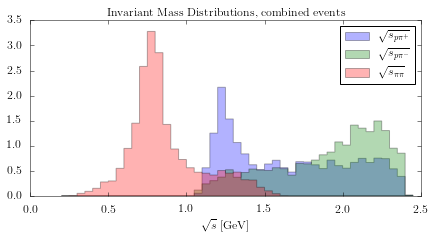

In [84]:
# Invariant mass histo
s_pipi_bins =  np.arange(0.2,2.5,0.05) 

a = plt.hist(s_ppi1,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^+}}$')
a = plt.hist(s_ppi2,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{p\pi^-}}$')
a = plt.hist(s_pipi,s_pipi_bins,weights=weight_list,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\sqrt{s_{\pi\pi}}$')

plt.xlabel(r'$\sqrt{s}$ [GeV]')
plt.title(r'Invariant Mass Distributions, combined events')
plt.legend()

## Cuts on combined events

In [85]:
# Lets select all backwards going pi+:
def costheta(p):
    px, py, pz = p[1], p[2], p[3]
    return pz/np.sqrt(px**2 + py**2 + pz**2)

# Compute cos theta for all 4 vectors
costheta_piplus_list = np.array([costheta(p) for p in pi1_four_vectors])

# Which 4 vectors pass?
# This is an array of bools, which can be used index the desired events
costheta_piplus_mask = costheta_piplus_list < 0.

# Subset of four vectors for which costheta_piplus_mask are True
pi1_four_vectors_cut = pi1_four_vectors[costheta_piplus_mask]
pi2_four_vectors_cut = pi2_four_vectors[costheta_piplus_mask]
p_four_vectors_cut = p_four_vectors[costheta_piplus_mask]
weight_list_cut = weight_list[costheta_piplus_mask]

In [86]:
# Get z components of the 4 vectors
pi1_pzs = pi1_four_vectors_cut[:,3]
pi2_pzs = pi2_four_vectors_cut[:,3]
p_pzs = p_four_vectors_cut[:,3]
print min(pi1_pzs), max(pi2_pzs)

-0.362981621339 2.8278537402


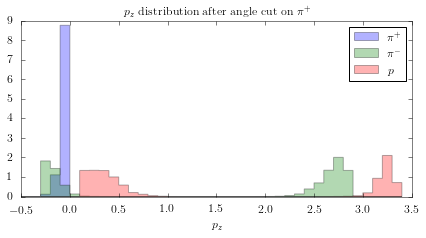

In [87]:
pz_bins = np.arange(-0.5,3.5,0.1)

a = plt.hist(pi1_pzs,pz_bins,weights=weight_list_cut,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^+$')
a = plt.hist(pi2_pzs,pz_bins,weights=weight_list_cut,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$\pi^-$')
a = plt.hist(p_pzs,pz_bins,weights=weight_list_cut,normed=True,alpha=0.3,edgecolor=None,histtype='stepfilled',label=r'$p$')
plt.xlabel(r'$p_z$')
plt.title(r'$p_z$ distribution after angle cut on $\pi^+$')
plt.legend()

#plt.savefig("graphics/IDM_Esum_hist_m1_10MeV.pdf", format='PDF', dpi=1000, bbox_inches='tight')